# Setup

In [ ]:
!pip install gymnasium==1.0.0 moviepy==1.0.3 matplotlib numpy

In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]
!pip install -q stable-baselines3[extra]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 16.9 MB/s eta 0:00:00


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

# ---------- Global plotting format (consistent across the notebook) ----------
def plot_curve(x, y, title, xlabel, ylabel, smooth_window=50):
    plt.figure(figsize=(10, 4))
    if smooth_window and len(y) >= smooth_window:
        y_s = np.convolve(y, np.ones(smooth_window)/smooth_window, mode="valid")
        x_s = x[len(x)-len(y_s):]
        plt.plot(x_s, y_s, label=f"smoothed (window={smooth_window})")
        plt.plot(x, y, alpha=0.25, label="raw")
    else:
        plt.plot(x, y, label="raw")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

print("Imports loaded.")


Imports loaded.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Create the environment

In [ ]:
ENV_ID = "LunarLander-v3"

# Number of parallel environments
n_envs = 8

# Training environment (vectorized)
train_env = make_vec_env(ENV_ID, n_envs=n_envs, seed=0)

# Separate evaluation environment
eval_env = gym.make(ENV_ID)

print("Environment:", ENV_ID)
print("Observation space:", eval_env.observation_space)
print("Action space:", eval_env.action_space)

Environment: LunarLander-v3
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# Training Plan and Success Criterion

We define **high performance** as:

- Mean episode reward ≥ **200**
- Measured over **50 evaluation episodes**

During training:
- The agent is evaluated periodically
- The best-performing model is saved automatically

## Training Stopping Criteria (Important)

In this notebook, the training process uses **two different notions of stopping**:

### Technical stopping (training budget)

The actual training stops after a **fixed number of environment steps**, defined by:

```python
TOTAL_TIMESTEPS = 1_200_000


In [ ]:
TARGET_MEAN_REWARD = 200
EVAL_EPISODES = 50
EVAL_FREQ = 25_000

run_id = time.strftime("%Y%m%d-%H%M%S")
log_dir = f"./ppo_lunarlander_{run_id}"
best_model_dir = os.path.join(log_dir, "best_model")
os.makedirs(best_model_dir, exist_ok=True)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=best_model_dir,
    log_path=log_dir,
    eval_freq=EVAL_FREQ,
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True,
)

print("Logs directory:", log_dir)
print("Best model dir:", best_model_dir)

Logs directory: ./ppo_lunarlander_20260122-182602
Best model dir: ./ppo_lunarlander_20260122-182602/best_model


# Build the PPO Agent

We use PPO with a multilayer perceptron (MLP) policy.
The state is an 8-dimensional vector, and actions are discrete.


In [ ]:
model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    verbose=1,
    tensorboard_log=log_dir,
    seed=0
)

print(model)

Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Train the Expert Agent

Training may take several minutes.
If training is too slow, reduce `TOTAL_TIMESTEPS`.


In [ ]:
TOTAL_TIMESTEPS = 1_200_000

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=eval_callback
)

print("Training finished.")

Logging to ./ppo_lunarlander_20260122-182602/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 89       |
|    ep_rew_mean     | -172     |
| time/              |          |
|    fps             | 2307     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -149        |
| time/                   |             |
|    fps                  | 1306        |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.010501301 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_varian

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=151.71 +/- 81.00
Episode length: 652.98 +/- 152.94
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 653        |
|    mean_reward          | 152        |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.00971049 |
|    clip_fraction        | 0.0979     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.96       |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.00519   |
|    value_loss           | 13.2       |
----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 760      |
|    ep_rew_mean     | 54.4     |
| time/    

# Evaluate the Trained Expert

We load the **best saved model** and evaluate it over 50 episodes.


In [ ]:
best_model_path = os.path.join(best_model_dir, "best_model.zip")
assert os.path.exists(best_model_path), "Best model not found. Did training run successfully?"

expert = PPO.load(best_model_path, env=eval_env)

mean_reward, std_reward = evaluate_policy(
    expert,
    eval_env,
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True
)

print(f"Expert mean reward: {mean_reward:.1f} ± {std_reward:.1f}")
print("Solved:", "YES" if mean_reward >= TARGET_MEAN_REWARD else "NO")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Expert mean reward: 269.0 ± 18.9
Solved: YES


# Plot Evaluation Curve

We visualize how the evaluation reward improves over training.

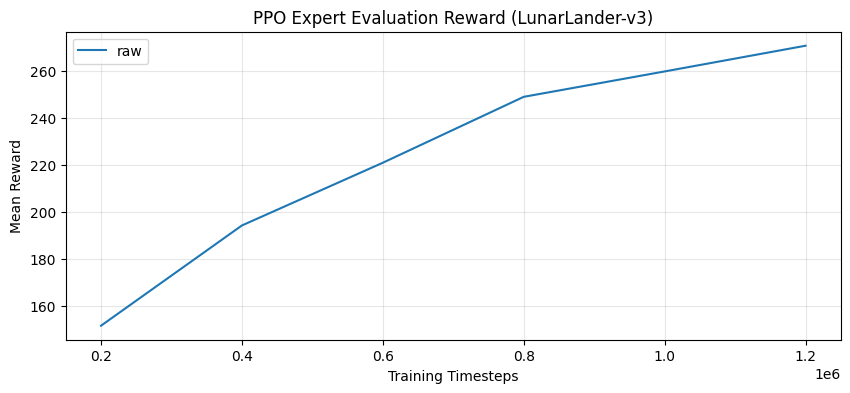

In [ ]:
eval_npz = os.path.join(log_dir, "evaluations.npz")
if not os.path.exists(eval_npz):
    print("No evaluations.npz found (EvalCallback may not have run).")
else:
    eval_data = np.load(eval_npz)
    timesteps = eval_data["timesteps"]
    results = eval_data["results"]
    mean_rewards = results.mean(axis=1)

    plot_curve(
        timesteps,
        mean_rewards,
        "PPO Expert Evaluation Reward (LunarLander-v3)",
        "Training Timesteps",
        "Mean Reward"
    )

# Save the Expert Model

This model will be used later for imitation learning.


In [ ]:
export_path = os.path.join(log_dir, "expert_ppo_lunarlander_v3.zip")
expert.save(export_path)
print("Expert model saved to:", export_path)

Expert model saved to: ./ppo_lunarlander_20260122-182602/expert_ppo_lunarlander_v3.zip


# Record a Video of the Expert

We record one episode to visually confirm correct behavior.


In [ ]:
from gymnasium.wrappers import RecordVideo

video_dir = os.path.join(log_dir, "video")
os.makedirs(video_dir, exist_ok=True)

video_env = gym.make(ENV_ID, render_mode="rgb_array")
video_env = RecordVideo(
    video_env,
    video_folder=video_dir,
    episode_trigger=lambda ep: True,
    name_prefix="expert"
)

obs, _ = video_env.reset(seed=0)
done = False
total_reward = 0.0

while not done:
    action, _ = expert.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = video_env.step(int(action))
    total_reward += float(reward)
    done = terminated or truncated

video_env.close()

print("Video recorded. Episode reward:", total_reward)
print("Video saved in:", video_dir)

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/ppo_lunarlander_20260122-182602/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Video recorded. Episode reward: 288.8774025257345
Video saved in: ./ppo_lunarlander_20260122-182602/video


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
from IPython.display import Video, display

video_folder = "./ppo_lunarlander_20251227-110320/video"
video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])

print("Found videos:", video_files)
assert video_files, "No .mp4 files found in the folder."

video_path = os.path.join(video_folder, video_files[0])
display(Video(video_path, embed=True))

Found videos: ['expert-episode-0.mp4']
